# 实验5_2 TensorFlow 石头剪刀布模型生成
## 1 准备工作
### 下载数据集
在终端内输入命令，将石头剪刀布的训练集和测试集下载至当前目录：  
`wget --no-check-certificate https://storage.googleapis.com/learning-datasets/rps.zip -O ./rps.zip`  
`wget --no-check-certificate https://storage.googleapis.com/learning-datasets/rps-test-set.zip -O ./rps-test-set.zip`  

解压数据集至当前目录：

In [1]:
import os
import zipfile

local_zip = './rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./')
zip_ref.close()

local_zip = './rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./')
zip_ref.close()

### 验证数据集
打印数据集的相关信息以验证数据集的完整性

In [2]:
rock_dir = os.path.join('./rps/rock')
paper_dir = os.path.join('./rps/paper')
scissors_dir = os.path.join('./rps/scissors')

# 各手势数据集包含的图片张数
print('total training rock images:', len(os.listdir(rock_dir)))
print('total training paper images:', len(os.listdir(paper_dir)))
print('total training scissors images:', len(os.listdir(scissors_dir)))

# 输出各数据集的前5张图片的文件名
rock_file = os.listdir(rock_dir)
rock_file.sort()
print(rock_file[:5])
paper_file = os.listdir(paper_dir)
paper_file.sort()
print(paper_file[:5])
scissors_file = os.listdir(scissors_dir)
scissors_file.sort()
print(scissors_file[:5])

total training rock images: 840
total training paper images: 840
total training scissors images: 840
['rock01-000.png', 'rock01-001.png', 'rock01-002.png', 'rock01-003.png', 'rock01-004.png']
['paper01-000.png', 'paper01-001.png', 'paper01-002.png', 'paper01-003.png', 'paper01-004.png']
['scissors01-000.png', 'scissors01-001.png', 'scissors01-002.png', 'scissors01-003.png', 'scissors01-004.png']


从石头、剪刀、布训练集中分别打印两张图片

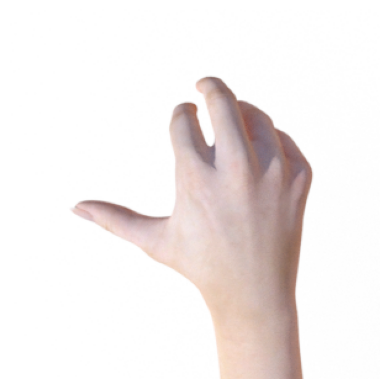

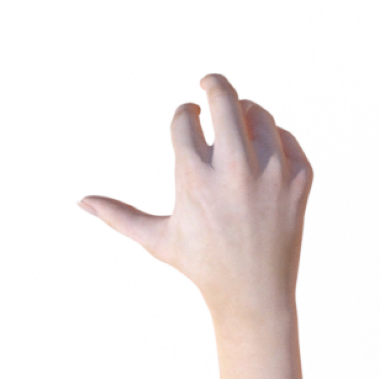

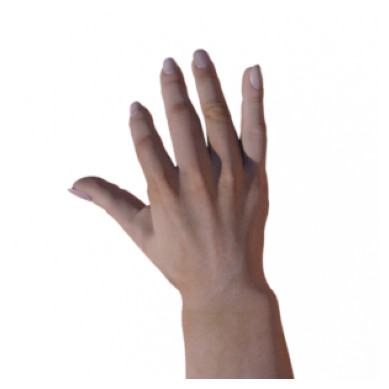

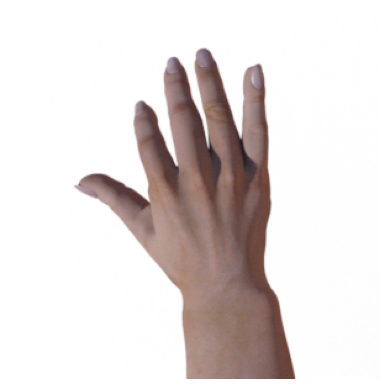

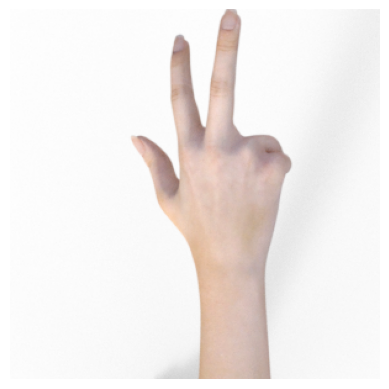

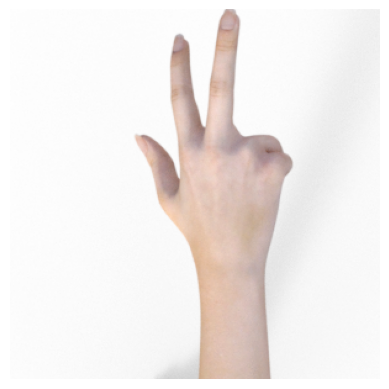

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 100

next_rock = [os.path.join(rock_dir, fname)
         for fname in rock_file[pic_index-2:pic_index]]
next_paper = [os.path.join(paper_dir, fname)
         for fname in paper_file[pic_index-2:pic_index]]
next_scissors = [os.path.join(scissors_dir, fname)
         for fname in scissors_file[pic_index-2:pic_index]]

for i, img_path in enumerate(next_rock + next_paper + next_scissors):
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('Off')
    plt.show()

## 2 模型生成
调用TensorFlow的keras进行数据模型的训练，ImageDataGenerator是Keras中图像预处理的类，经过预处理使得后续的训练更加准确。

In [3]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = './rps/'
# 图片预处理
training_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

VALIDATION_DIR = "./rps-test-set/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(150,150),
    class_mode='categorical',
    batch_size=126
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(150,150),
    class_mode='categorical',
    batch_size=126
)

# 定义模型架构
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

# 编译模型并定义相关参数
model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

# 用训练数据拟合
history = model.fit(train_generator, epochs=25, steps_per_epoch=20, validation_data = validation_generator, verbose = 1, validation_steps=3)


Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_____________________________________

将生成的模型以h5格式保存到当前目录

In [2]:
model.save("rps.h5")

## 3 模型评估
通过绘制图形的方式，验证生成模型的性能

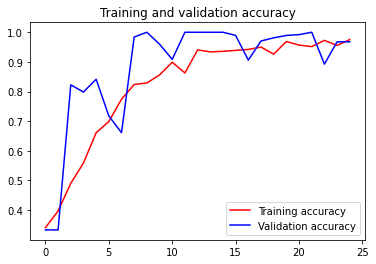

<Figure size 432x288 with 0 Axes>

In [4]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()